## Week 12 Lecture 1

We have studied three approaches to extending linear models. We have added explanatory variables by

- taking polynomial transformations involving products of features 
- applying one-hot encoding to categorical data 
- transforming independent variables and dependent variables with logarithms

While adding explanatory variables improves the accuracy of the predictions in the sample, we need to look outside of the sample to the population. Here adding explanatory variables might worsen the accuracy of the predictions. So we will study two samples

- training set
- testing set 

We will fit the model to the data in the training set. We will validate the accuracy of the predictions on the testing set. The testing set substitutes for the population helping us to access the predictions. Data scientists must ask  

> How does my model capture the population? Will my predictions generalize from in-sample to out-of-sample?

We will study a dataset about fuel efficiency. Following an exercise on gradient descent, we will study the impact of adding features. 

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 7)

from sklearn.linear_model import LinearRegression

We will study a dataset on the fuel of efficiency of cars. Note the mpg is an acronym for miles per gallon. If the mpg is high, then the car has good fuel efficiency.

In [2]:
cars = sns.load_dataset('mpg').dropna()
cars

,mpg,cylinders,displacement,horsepower,...,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,...,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,...,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,...,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,...,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,...,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,...,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,...,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,...,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,...,18.6,82,usa,ford ranger


Note that we have 392 records with 9 features. We take `mpg` for the response variable 

- `cylinders`
- `displacement`
- `horsepower`
- `weight`
- `acceleration`
- `model_year`
- `origin`
- `name`

for the explanatory variables. Note that `origin`, `model_year`, and `name` are qualitative variables. 

### Exercise (Gradient Descent) 

What is the relationship between `mpg` and `horsepower`? 

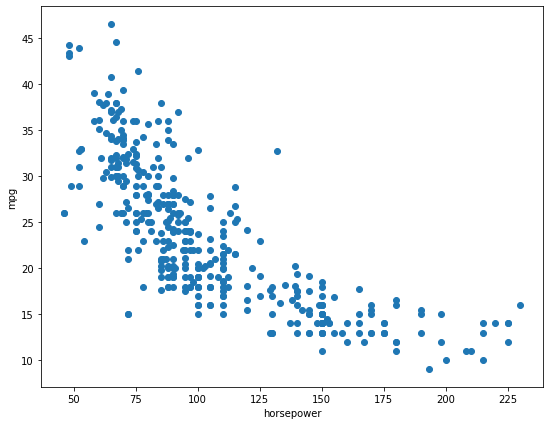

In [3]:
plt.scatter(cars['horsepower'], cars['mpg'])
plt.xlabel("horsepower")
plt.ylabel("mpg");

Note that the variables have a different scale. Horsepower can have two to three digits but mpg has one to two digits. We should transform the data to have mean 0 and standard deviation 1. 

## Standard Units


In [4]:
def transform_to_standard_unit(array):
    return (array - np.mean(array)) / np.std(array) 

In [5]:
mpg_hp = cars.copy()[["mpg","horsepower"]]

mpg_hp["mpg"] = transform_to_standard_unit(mpg_hp["mpg"])
mpg_hp["horsepower"] = transform_to_standard_unit(mpg_hp["horsepower"])

We can compute the correlation to understand the association between `mpg` and `horsepower`m

In [6]:
cars[['mpg','horsepower']].corr()

,mpg,horsepower
mpg,1.000000,-0.778427
horsepower,-0.778427,1.000000


We find a negative correlation. So if the horsepower increases then we expect the mpg to decrease. We should try to fit a linear model to the data. 

In [7]:
def linear_model(intercept, slope, X):
    return intercept + slope * X

Remember that we have two parameters for the linear model because we have one explanatory variable. We can choose different values for the slope and the intercept. So to fit the data we use loss functions. 

In [8]:
def mse(intercept, slope, X, y):
    return np.mean((y - linear_model(intercept, slope, X)) ** 2)

For linear regression we take the square loss. Remember that a loss function measures the difference between predicted value and observed value. By calculating the average of the loss functions over the sample, we can measure the accuracy of the predictions.  

In [9]:
def linear_model_derivative(intercept, slope, X, y):
    residual = linear_model(intercept, slope, X) - y
    
    derivative_with_respect_intercept = 2 * np.mean(residual)
    derivative_with_respect_slope = 2 * np.mean(residual * X)
    
    return np.array([derivative_with_respect_intercept, derivative_with_respect_slope])

Remember that we need to take the derivative with respect to intercept and the derivative with respect to slope. So for 
$$L(a,b; x_1,\ldots,x_n,y_1,\ldots,y_n) = \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2$$ we have  
 $$\frac{d L}{d a} = \frac{2}{n} \sum_{i=1}^n \; a + b x_i - y_i$$ and
 $$\frac{d L}{d b} = \frac{2}{n} \sum_{i=1}^n \; (a + b x_i - y_i) x_i$$ Here the difference $$a + b x_i - y_i$$ is the residual.

In [10]:
def gradient_descent(derivative, X, y, initial_guess, learning_rate, stopping_condition):
    slopes = []
    intercepts = []
    errors = []
        
    iteration = 0    
    guess = initial_guess()
    
    while stopping_condition(iteration, errors): 
        slope = guess[1]
        intercept = guess[0]
        
        guess = guess - learning_rate(iteration) * derivative(intercept, slope, X, y)
        
        slopes.append(slope)
        intercepts.append(intercept)
        errors.append(mse(intercept, slope, X, y))
        
        iteration = iteration + 1
        
    return slopes, intercepts, errors 

Remember the components of gradient descent: 

- Initial Guess 
- Learning Rate
- Stopping Condition

Before we explore these components, we should check the implementation. 

In [11]:
X = mpg_hp["horsepower"].values
y = mpg_hp["mpg"].values

derivative = linear_model_derivative

def initial_guess():
    return np.array([1,1])

def learning_rate(iteration):
    return 0.1

def stopping_condition(iteration, errors):
    return iteration < 100

slopes, intercepts, errors = gradient_descent(derivative, X, y, initial_guess, learning_rate, stopping_condition)

We can print the outputs.

In [12]:
for index in range(-5,-1): 
    print("slope: {} | intercept: {} | error: {}".format(slopes[index], intercepts[index], errors[index]))

slope: -0.7784267827922099 | intercept: 6.216540532841826e-10 | error: 0.3940517421105651
slope: -0.7784267830133231 | intercept: 4.973232382530457e-10 | error: 0.3940517421105651
slope: -0.7784267831902137 | intercept: 3.978585840530054e-10 | error: 0.3940517421105651
slope: -0.7784267833317262 | intercept: 3.1828686069297316e-10 | error: 0.3940517421105651


However it can be informative to plot the data and the residuals to assess the fit.

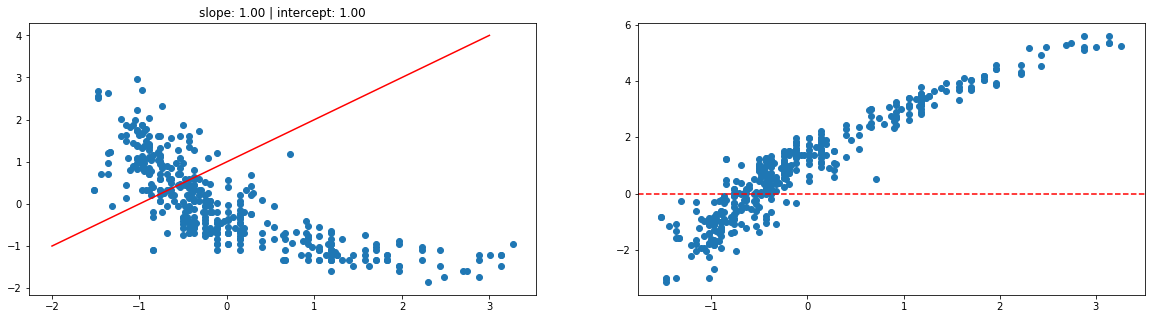

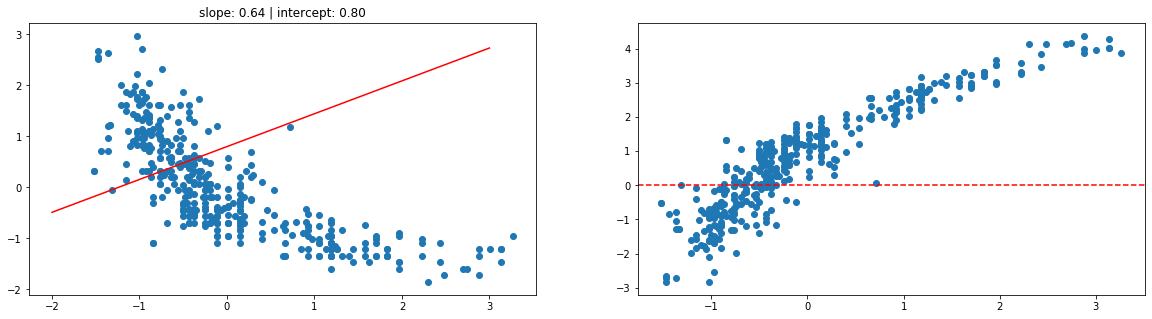

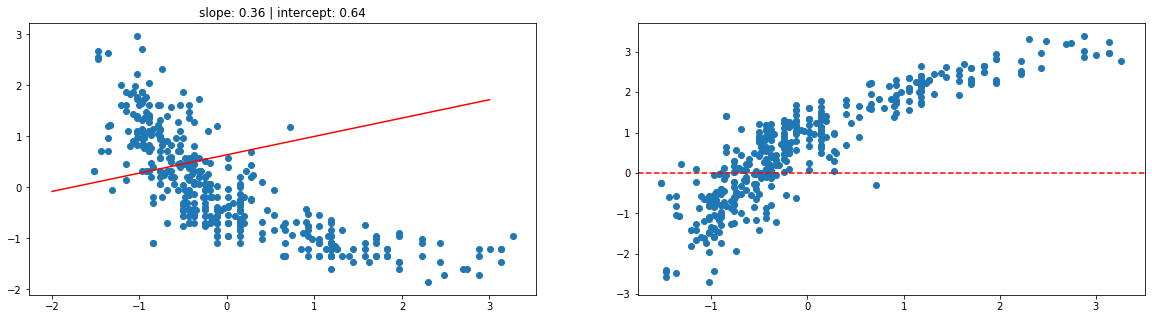

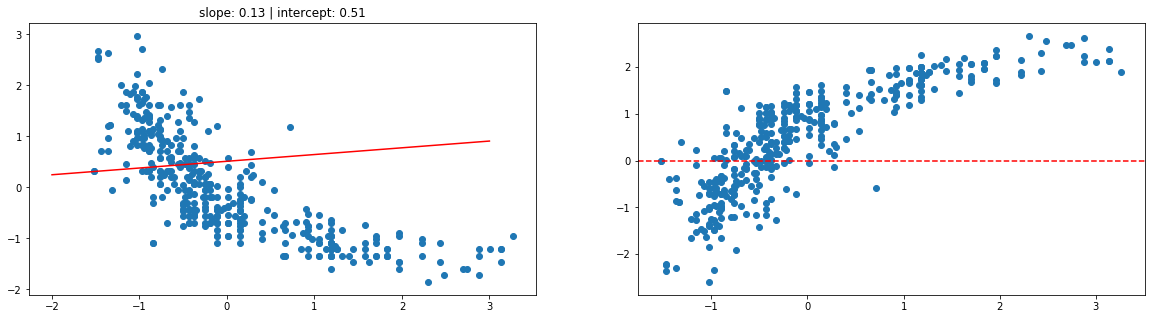

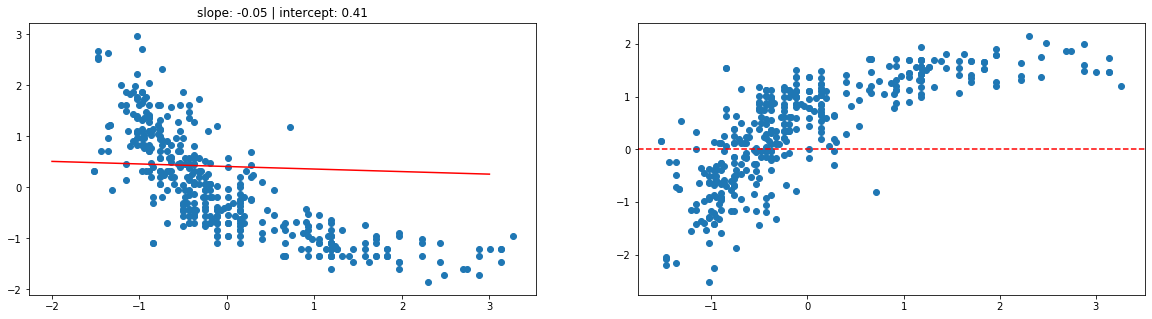

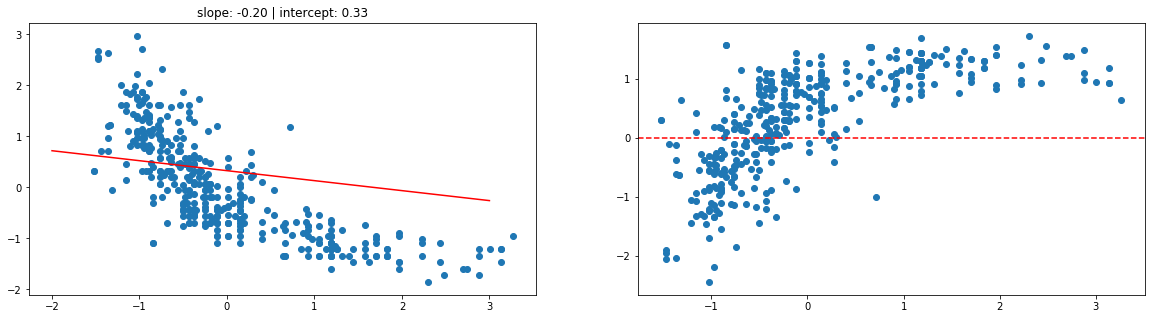

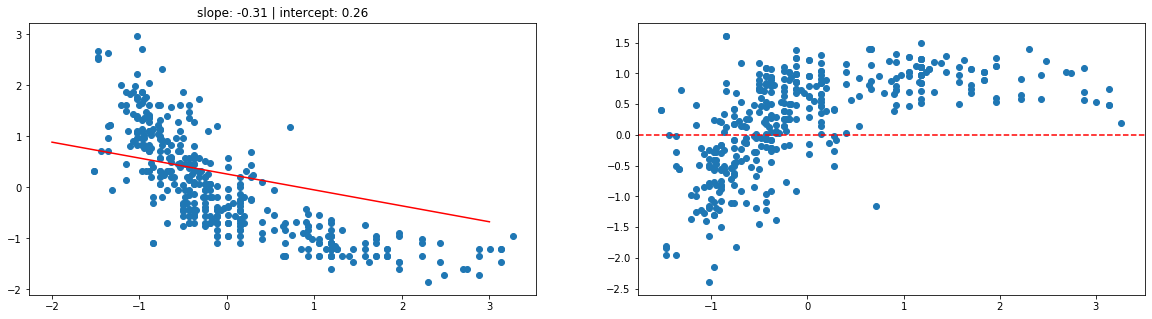

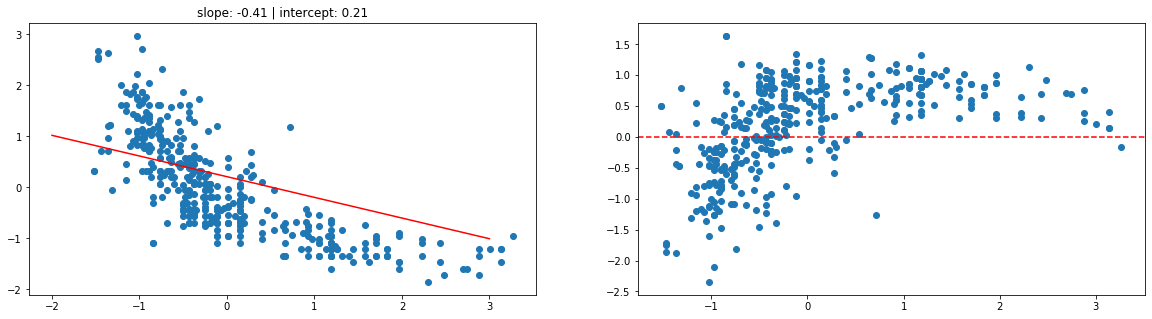

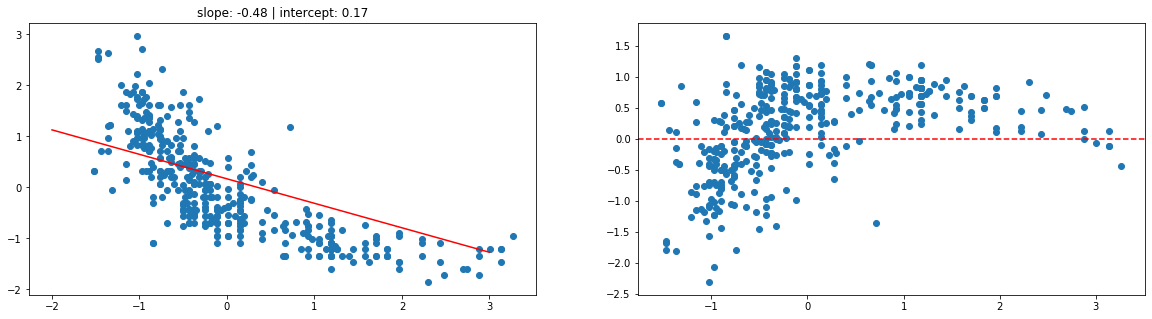

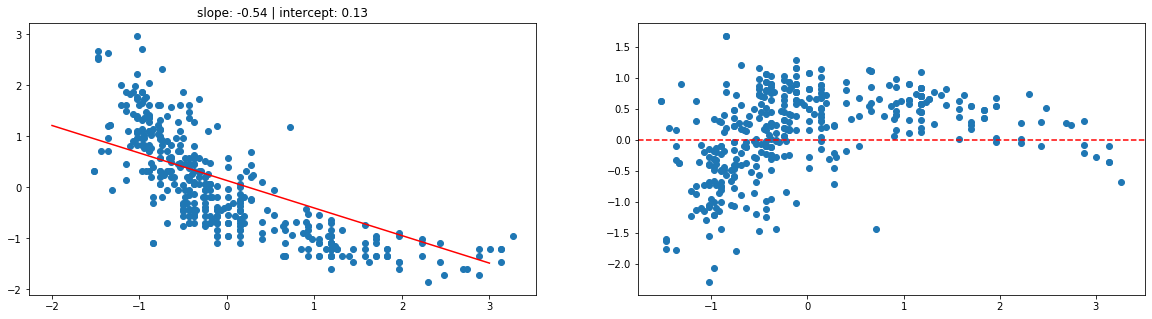

In [13]:
for slope, intercept in zip(slopes[:10], intercepts[:10]):
    fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(20,5))
    
    xrange = np.linspace(-2,3, 200)
    yrange = slope * xrange + intercept
    ax[0].scatter(X, y)
    ax[0].plot(xrange, yrange, c='r')
    ax[0].set_title("slope: {:.2f} | intercept: {:.2f}".format(slope, intercept))
   
    residuals = linear_model(intercept, slope, X) - y
    ax[1].scatter(X, residuals)
    ax[1].axhline(y=0, color = "red", linestyle="dashed")
    plt.show();

Each iteration improves the accuracy of the prediction. Note that without transforming the features to have mean 0 and standard deviation 1, gradient descent would have diverged from the minimum with the initial guess and learning rate. 

##### Initial Guess 

Usually we take the initial guess to have 

 * all parameters equal to the same number
 * random numbers for each parameter

We could take all the parameters to be 1. Or we could randomly generate a number between 0 and 1. However, we sometimes try to gradient descent on functions with local minima. Here we might need to try many different combinations of parameters to get close to the global minimum. 
 


We can check the difference in slope and intercept with a random initial guess.

In [14]:
X = mpg_hp["horsepower"].values
y = mpg_hp["mpg"].values

derivative = linear_model_derivative

def initial_guess():
    return np.random.rand(2)

def learning_rate(iteration):
    return 0.1

def stopping_condition(iteration, errors):
    return iteration < 100

slopes, intercepts, errors = gradient_descent(derivative, X, y, initial_guess, learning_rate, stopping_condition)

In [15]:
for index in range(-5,-1): 
    print("slope: {} | intercept: {} | error: {}".format(slopes[index], intercepts[index], errors[index]))

slope: -0.778426782830979 | intercept: 4.85540604706417e-10 | error: 0.3940517421105651
slope: -0.7784267830443384 | intercept: 3.884324836156153e-10 | error: 0.39405174211056504
slope: -0.778426783215026 | intercept: 3.107459860179303e-10 | error: 0.3940517421105651
slope: -0.778426783351576 | intercept: 2.485967886648259e-10 | error: 0.3940517421105651


##### Learning Rate

Remember that the learning rate control the jump between iteration. If the learning rate is large, then we have a large change. If the learning rate is small then we have a small change. Usually the learning rate is

 * fixed number 
 * collection of number labeled by the iteration
 
If we decide to have a different learning rate for each iteration, then we should decrease the values. So the early iterations allow us to make large changes but the later iterations make small changes to avoid missing the minimum.

In [16]:
X = mpg_hp["horsepower"].values
y = mpg_hp["mpg"].values

derivative = linear_model_derivative

def initial_guess():
    return np.array([1,1])

def learning_rate(iteration):
    return 1 / (iteration + 1)

def stopping_condition(iteration, errors):
    return iteration < 100

slopes_rate, intercepts_rate, errors_rate = gradient_descent(derivative, X, y, initial_guess, learning_rate, stopping_condition)

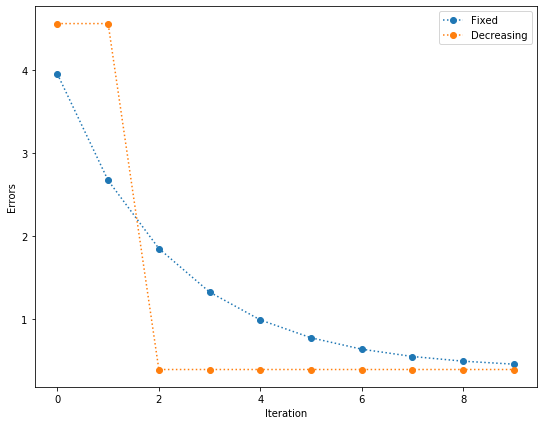

In [17]:
plt.plot(np.arange(10), errors[:10],"o:", label ="Fixed")
plt.plot(np.arange(10), errors_rate[:10],"o:", label ="Decreasing")
plt.legend()
plt.ylabel("Errors")
plt.xlabel("Iteration");

##### Stopping Condition
We need some plan for stopping the iterations. Usually we stop the iterations after

 * we get to a maximum number of iterations 
 * the values of the parameters are not changing much between iterations 
 * the value of the average loss is not changing much between iterations
 
We might not know the number of iterations. So it could be helpful to use the values of the parameters or average loss.
 

In [18]:
X = mpg_hp["horsepower"].values
y = mpg_hp["mpg"].values

derivative = linear_model_derivative

def initial_guess():
    return np.array([1,1])

def learning_rate(iteration):
    return 0.1

def stopping_condition(iteration, errors):
    output = True
    
    if len(errors) > 1:
        output = (errors[-2] - errors[-1] > 0.001)
        
    return output 

slopes, intercepts, errors = gradient_descent(derivative, X, y, initial_guess, learning_rate, stopping_condition)

In [19]:
for index in range(len(slopes)): 
    print("iteration: {} | slope: {} | intercept: {} | error: {}".format(index, slopes[index], intercepts[index], errors[index]))

iteration: 0 | slope: 1 | intercept: 1 | error: 4.556853567795551
iteration: 1 | slope: 0.6443146432204448 | intercept: 0.8 | error: 3.0582449105489564
iteration: 2 | slope: 0.35976635779680083 | intercept: 0.6400000000000001 | error: 2.099135369911136
iteration: 3 | slope: 0.1321277294578855 | intercept: 0.5120000000000001 | error: 1.4853052639029307
iteration: 4 | slope: -0.04998317321324677 | intercept: 0.40960000000000013 | error: 1.0924539960576791
iteration: 5 | slope: -0.1956718953501526 | intercept: 0.32768000000000014 | error: 0.841029184636718
iteration: 6 | slope: -0.3122228730596773 | intercept: 0.2621440000000001 | error: 0.6801173053273031
iteration: 7 | slope: -0.405463655227297 | intercept: 0.2097152000000001 | error: 0.5771337025692774
iteration: 8 | slope: -0.4800562809613928 | intercept: 0.1677721600000001 | error: 0.511224196804141
iteration: 9 | slope: -0.5397303815486695 | intercept: 0.1342177280000001 | error: 0.4690421131144537
iteration: 10 | slope: -0.58746966

### Features

Remember that the `origin` column contains the manufacturing region of the car.  

In [20]:
cars['origin'].value_counts()

usa       245
japan      79
europe     68
Name: origin, dtype: int64

Should we incorporate the `origin` feature into a linear model?

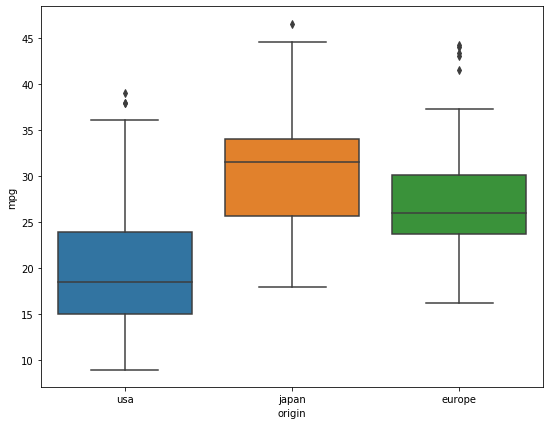

In [21]:
sns.boxplot(x='origin', y='mpg', data=cars);

We see that `mpg` differs between the countries. So we should try to incorporate it into the model. Remember that we can use a one-hot encoding. 

In [22]:
origin_japan = cars['origin'] == 'japan'
origin_europe = cars['origin'] == 'europe'

one_hot = pd.DataFrame({
    'intercept': 1,
    'origin=japan': origin_japan.astype(int),
    'origin=europe': origin_europe.astype(int),
})

one_hot

,intercept,origin=japan,origin=europe
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
393,1,0,0
394,1,0,1
395,1,0,0
396,1,0,0


Remember that we omit the `usa` in the presence of an intercept column. We want to avoid redundancy in the columns.

In [23]:
one_hot = cars.copy()[['origin']]
one_hot["intercept"] = 1
one_hot = pd.get_dummies(one_hot, drop_first=True)
one_hot

,intercept,origin_japan,origin_usa
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,0,1
...,...,...,...
393,1,0,1
394,1,0,0
395,1,0,1
396,1,0,1


We found a pattern in the residuals between observed `mpg` and predicted `mpg` from `horsepower`. We can try a polynomial transformation to match a non-linear relationship betwen `mpg` and `horsepower`.  

In [24]:
def add_powers(column, n):
    data = {"power{}".format(number) : column**(number) for number in range(n+1)} 
    return pd.DataFrame(data = data)

We can use the tranformation with `n` equal to 2 on the `horsepower` column.

In [25]:
hp = add_powers(cars["horsepower"], 2)
hp

,power0,power1,power2
0,1.0,130.0,16900.0
1,1.0,165.0,27225.0
2,1.0,150.0,22500.0
3,1.0,150.0,22500.0
4,1.0,140.0,19600.0
...,...,...,...
393,1.0,86.0,7396.0
394,1.0,52.0,2704.0
395,1.0,84.0,7056.0
396,1.0,79.0,6241.0


Remember that we can use `LinearRegression` in the scikit-learn package for linear regression.

In [26]:
nonlinear_model = LinearRegression(fit_intercept=False)
nonlinear_model.fit(hp, cars["mpg"])

predictions = nonlinear_model.predict(hp)
residuals = predictions - cars["mpg"].values 

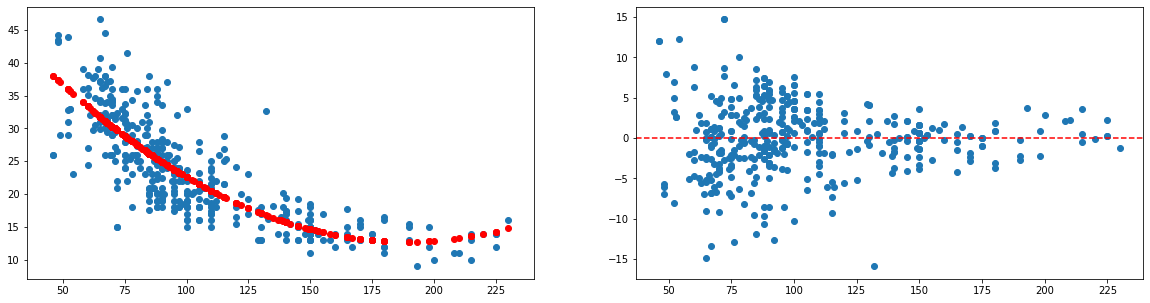

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(20,5))

ax[0].scatter(cars["horsepower"].values, cars["mpg"].values)
ax[0].scatter(cars["horsepower"].values, predictions, c='r')

ax[1].scatter(cars["horsepower"].values, residuals)
ax[1].axhline(y=0, color = "red", linestyle="dashed")
plt.show();

We can add the `origin` feature. 

In [28]:
hp_one_hot  = pd.merge(left = hp, right = one_hot, left_index=True, right_index=True)
hp_one_hot = hp_one_hot.drop(columns = ["intercept"]) 
hp_one_hot

,power0,power1,power2,origin_japan,origin_usa
0,1.0,130.0,16900.0,0,1
1,1.0,165.0,27225.0,0,1
2,1.0,150.0,22500.0,0,1
3,1.0,150.0,22500.0,0,1
4,1.0,140.0,19600.0,0,1
...,...,...,...,...,...
393,1.0,86.0,7396.0,0,1
394,1.0,52.0,2704.0,0,0
395,1.0,84.0,7056.0,0,1
396,1.0,79.0,6241.0,0,1


If we fit another model, then we can make more accurate predictions.

In [29]:
nonlinear_model = LinearRegression(fit_intercept=False)
nonlinear_model.fit(hp_one_hot, cars["mpg"])

predictions = nonlinear_model.predict(hp_one_hot)
residuals = predictions - cars["mpg"].values 

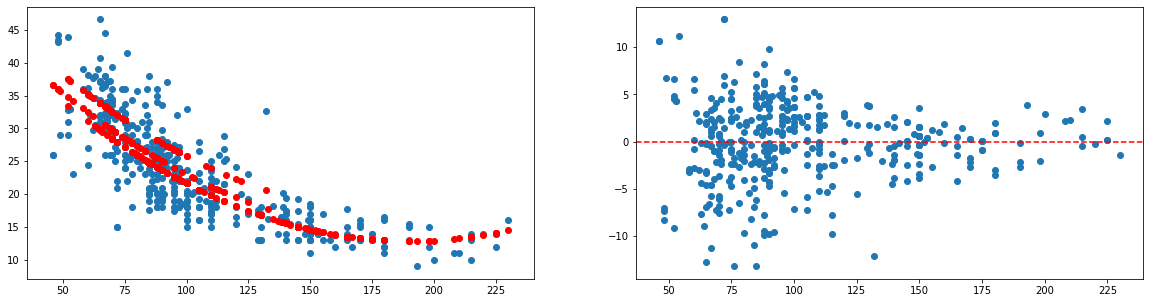

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(20,5))

ax[0].scatter(cars["horsepower"].values, cars["mpg"].values)
ax[0].scatter(cars["horsepower"].values, predictions, c='r')

ax[1].scatter(cars["horsepower"].values, residuals)
ax[1].axhline(y=0, color = "red", linestyle="dashed")
plt.show();

Note that we have three curve corresponding to the three regions.

### Overfitting and Underfitting

We find that adding features improves the accuracy of predictions. However, we need to remember that we want to make predictions about a population not a sample.

In [31]:
def plotting_helper_function(data, degree, xrange):
    hp = add_powers(data, degree)

    nonlinear_model = LinearRegression(fit_intercept=False)
    nonlinear_model.fit(hp, cars["mpg"]) 

    predictions = nonlinear_model.predict(hp)
    hp_mse = np.mean((predictions - cars["mpg"].values)**2)

    to_draw = add_powers(pd.Series(data=xrange), degree)
    return nonlinear_model.predict(to_draw), hp_mse

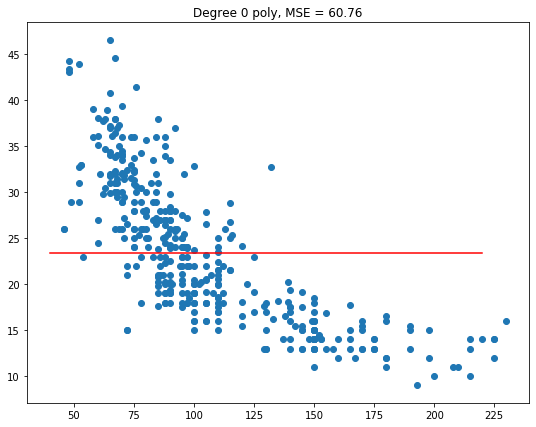

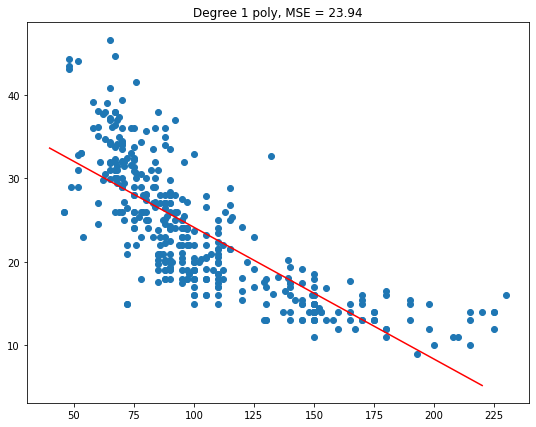

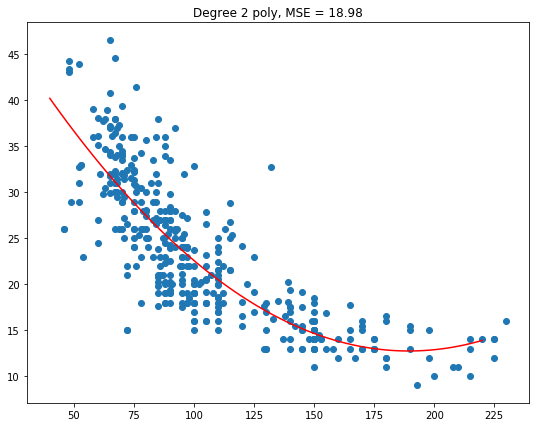

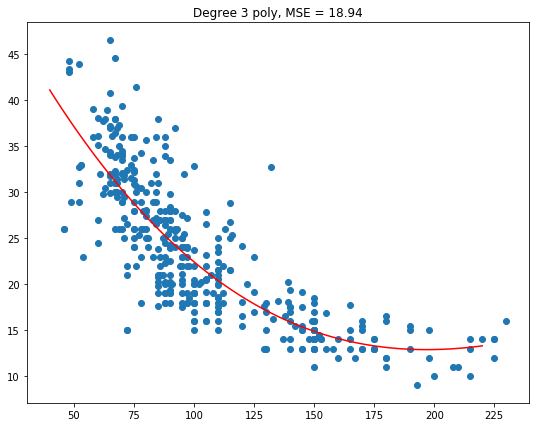

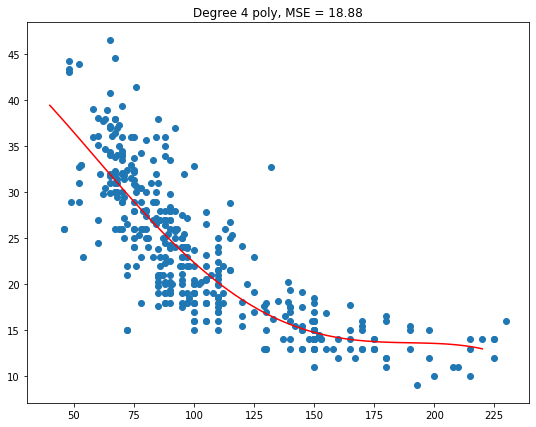

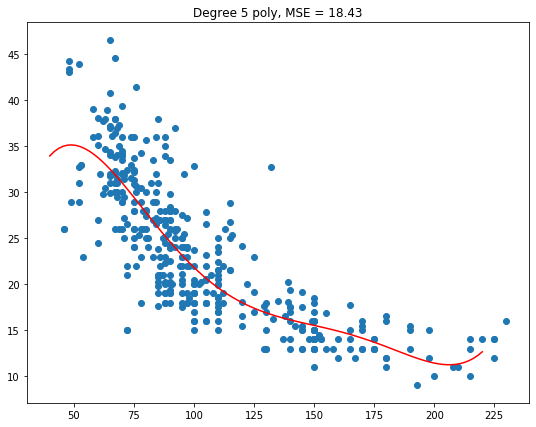

In [32]:
max_degree = 6
xrange = np.linspace(40, 220, 100)

for degree in range(0,max_degree):
    yrange, hp_mse = plotting_helper_function(cars["horsepower"], degree,xrange)
    
    plt.scatter(cars["horsepower"].values, cars["mpg"].values)
    plt.plot(xrange, yrange, c='r')
    
    plt.title(f'Degree {degree} poly, MSE = {hp_mse:.2f}')    
    plt.show();

We note that the mean square error descrease with more and more features. Instead of looking at the sample, we should try to split the sample into a training set and a testing set. 

In [33]:
mpg_hp = cars.copy()[["mpg","horsepower"]]

mpg_hp["mpg"] = transform_to_standard_unit(mpg_hp["mpg"])
mpg_hp["horsepower"] = transform_to_standard_unit(mpg_hp["horsepower"])

Here we make copies of the `mpg` and `horsepower` columns. We convert to standard units. 

In [34]:
number_of_rows = len(mpg_hp)
RANDOM_STATE = 47

mpg_hp_shuffled = mpg_hp.sample(n= number_of_rows, replace = False, random_state = RANDOM_STATE)

Here we have shuffled the rows of the table `cars`. By sampling with replacement, we have put the rows in a random order. So we can split into 90% training set and 10% testing set.

In [35]:
training_set = mpg_hp_shuffled[:int(0.9 * number_of_rows)]
testing_set = mpg_hp_shuffled[int(0.9 * number_of_rows):]

We have to randomly shuffle the dataset before splitting into training set and test set. Otherwise, we might bias the study. For example suppose we took training set to be `usa` and testing set to be `europe` and `japan`. Remember that `usa` has worse fueld efficiency than `europe` and `japan`. So we would fit a model to data predicting low `mpg` but we would evaluate the model on data with high `mpg`. 

In [36]:
def compute_training_testing_errors(training_set, testing_set, degree):
    hp_train = add_powers(training_set["horsepower"], degree)
    hp_test = add_powers(testing_set["horsepower"], degree)

    nonlinear_model = LinearRegression(fit_intercept=False, normalize = True)
    nonlinear_model.fit(hp_train, training_set["mpg"]) 

    predictions_training = nonlinear_model.predict(hp_train)
    mse_training = np.mean((predictions_training - training_set["mpg"].values)**2)

    predictions_testing = nonlinear_model.predict(hp_test)
    mse_testing = np.mean((predictions_testing - testing_set["mpg"].values)**2)
    
    return mse_training, mse_testing

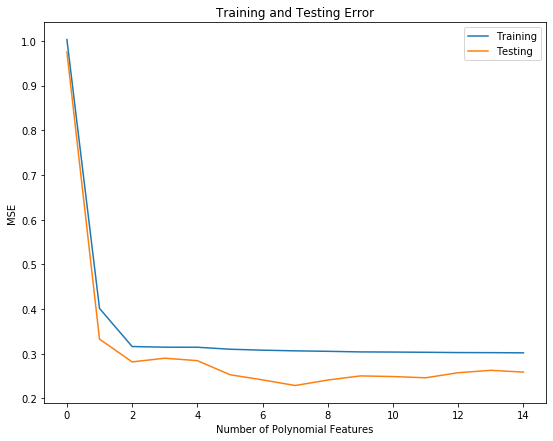

In [37]:
degrees = np.arange(15)

training_errors = []
testing_errors = []

for degree in degrees:
    mse_training, mse_testing = compute_training_testing_errors(training_set, testing_set, degree)
    training_errors.append(mse_training)
    testing_errors.append(mse_testing)
    
plt.plot(degrees, training_errors, label = "Training")
plt.plot(degrees, testing_errors, label = "Testing")
plt.title('Training and Testing Error')
plt.xlabel('Number of Polynomial Features')
plt.ylabel('MSE')
plt.legend();